*Antonio Coín Castro*


# Bayesian Functional Linear Regression

In [7]:
from matplotlib import pyplot as plt
import arviz as az
import numpy as np
import pandas as pd
import pickle
import scipy
from multiprocessing import Pool
import utils

In [8]:
# Extensions

%load_ext autoreload
%autoreload 2

# Plotting configuration

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 4]
plt.style.use('arviz-darkgrid')
NCOLS = 3


def NROWS(x, ncols=NCOLS):
    return np.ceil(x/ncols).astype('int')


# Randomness and reproducibility
SEED = 42
np.random.seed(SEED)
rng = np.random.default_rng(SEED)

# Floating point precision for display
np.set_printoptions(precision=3, suppress=True)
pd.set_option("display.precision", 3)

# Multiprocessing
N_CORES = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We consider the model

$$
Y_i = \mu + \Psi^{-1}_{X_i}(\alpha) + \varepsilon_i,
$$

i.e.,

$$
Y_i \sim \mathcal N\left(\mu + \sum_{j=1}^p \beta_jX_i(t_j), \ \sigma^2\right).
$$

The prior distributions we choose are:

\begin{align*}
  \pi(\mu, \sigma^2)              & \propto 1/\sigma^2,                                                     \\
  \tau                     & \sim \mathscr U([0, 1]^p),                                              \\
  \beta\mid \tau, \sigma^2 & \sim \mathcal N(b_0, g\sigma^2(\mathcal X_\tau' \mathcal X_\tau + \eta I)^{-1}),
\end{align*}

Writing the parameter vector as $\theta = (\beta, \tau, \mu, \sigma^2)$, the joint posterior probability is:

$$
\pi(\beta, \tau, \mu, \sigma^2\mid Y) \propto \frac{|G_\tau|^{1/2}}{\sigma^{p+n+2}} \exp\left\{ -\frac{1}{2\sigma^2} \left(\|Y- \mu\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right) \right\}.
$$

Hence, the log-posterior probability is:

$$
\log \pi(\beta, \tau, \mu, \sigma^2\mid Y) \propto \frac{1}{2}\log |G_\tau| - (p+n+2)\log \sigma -\frac{1}{2\sigma^2} \left(\|Y-\mu\boldsymbol{1} - \mathcal X_\tau\beta\|^2 + \frac{1}{g}(\beta - b_0)'G_\tau(\beta - b_0) \right).  
$$

Note that for computational reasons we will work with $\log \sigma$ instead of $\sigma^2$, and hence the associated prior distribution is

$$
\pi(\mu, \log\sigma) \propto 1.
$$

## Example dataset

We generate a toy dataset with $n=200$ functional regressors $X_i(t) \sim BM$, a response variable given by a "simple" RKHS function, a value of $\mu=5$ and a variance of $\sigma^2=1$:

$$
Y_i \sim \mathcal N\big(5 -5X_i(0.1) + 10X_i(0.8), \ 1\big).
$$

We consider a regular grid of $N=100$ points on $[0, 1]$.

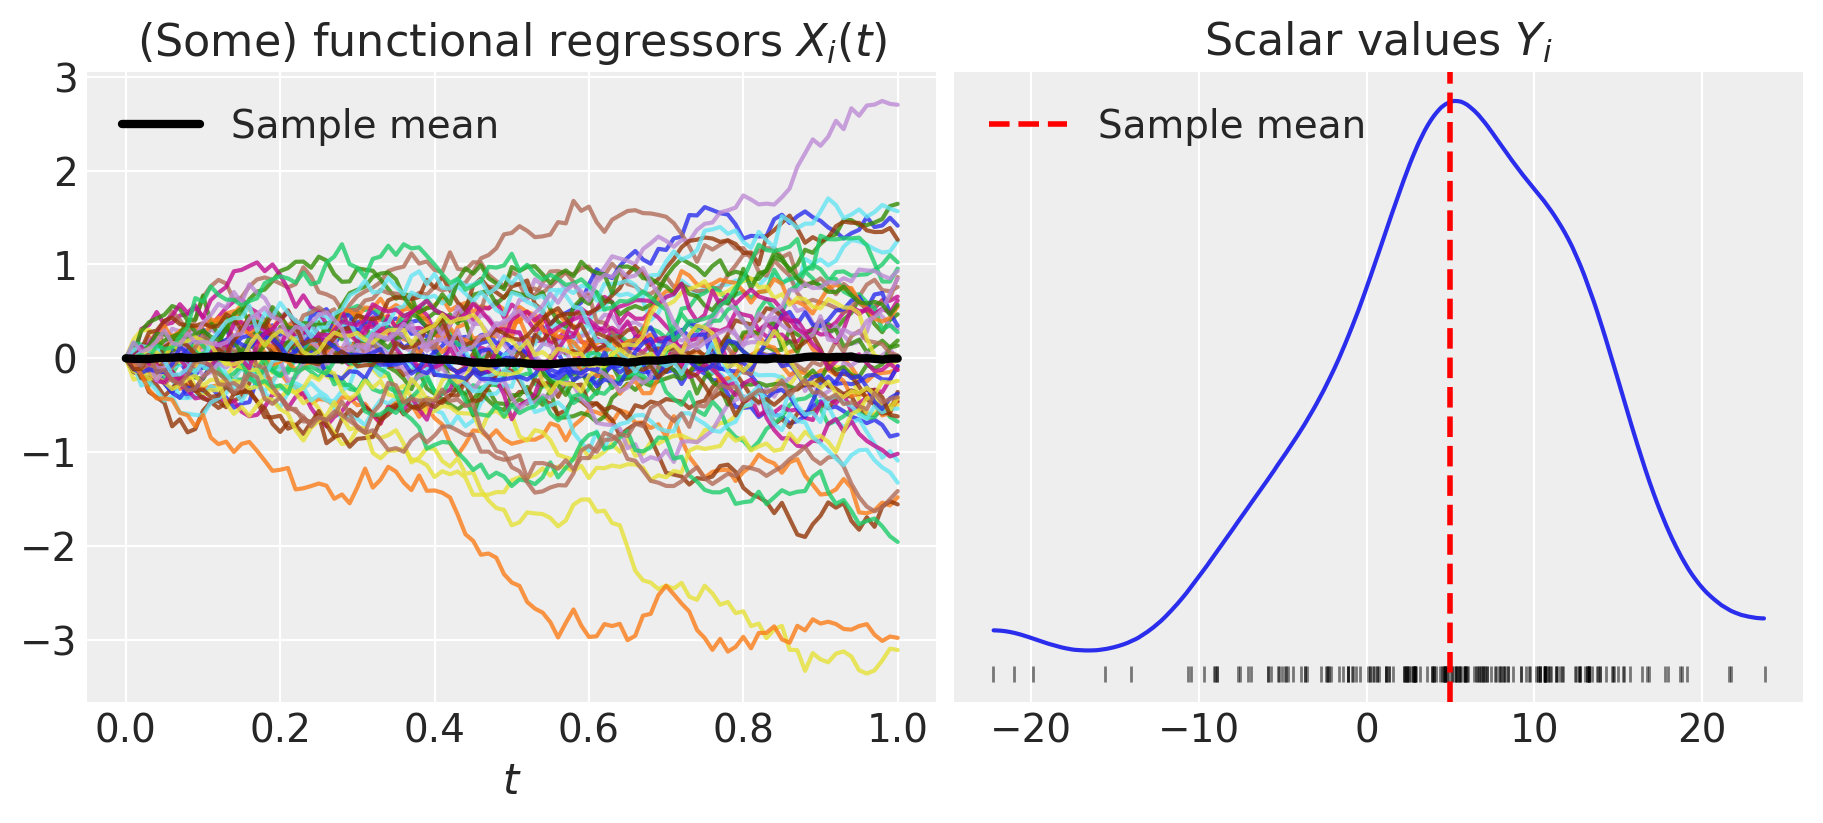

In [9]:
def brownian_kernel(s, t, sigma=1.0):
    return sigma*np.minimum(s, t)


N = 100
n = 200
grid = np.linspace(0., 1., N + 1)
beta_true = np.array([-5., 10.])
tau_true = np.array([0.1, 0.8])
mu_true = 5
sigma2_true = 1.0
theta_names = ["beta", "tau", "mu", "sigma2"]

X, Y = utils.generate_gp_dataset(
    rng, grid, brownian_kernel, n,
    beta_true, tau_true, mu_true, sigma2_true
)

utils.plot_dataset(X, Y, grid)

# Standardize data
X_m = X.mean(axis=0)
X = X - X_m

We will try to recover the model using $p=3$.

In [10]:
p_hat = 3
theta_ndim = 2*p_hat + 2
g = 5
eta = 0.1
sd_beta_init = 5
sd_mu_init = 10*np.abs(Y.mean())  # Grollemund et al (?)
sd_log_sigma_init = 1

# Labels
labels = []
for i in range(p_hat):
    labels.append(fr"$\beta_{i + 1}$")
for i in range(p_hat):
    labels.append(fr"$t_{i + 1}$")
labels.append(r"$\mu$")
labels.append(r"$\sigma^2$")

# Labels for pymc
labeller = az.labels.MapLabeller(
    var_name_map={
        "beta": r"$\beta$",
        "tau": r"$\tau$",
        "mu": r"$\mu$",
        "sigma2": r"$\sigma^2$",
    })


def initial_guess_random(p, sd_beta, sd_mu, sd_log_sigma, n_walkers=1):
    beta_init = sd_beta*rng.standard_normal(size=(n_walkers, p))
    tau_init = rng.uniform(size=(n_walkers, p))
    mu_init = sd_mu*rng.standard_normal(size=(n_walkers, 1))
    log_sigma_init = sd_log_sigma*rng.standard_normal(size=(n_walkers, 1))

    init = np.hstack((
        beta_init,
        tau_init,
        mu_init,
        log_sigma_init
    ))

    return init if n_walkers > 1 else init[0]


def intial_guess_around_value(value, p, sd_beta=1, sd_tau=0.1, sd_mu=1, sd_log_sigma=0.5, n_walkers=1):
    beta_jitter = sd_beta*rng.standard_normal(size=(n_walkers, p))
    tau_jitter = sd_tau*rng.standard_normal(size=(n_walkers, p))
    mu_jitter = sd_mu*rng.standard_normal(size=(n_walkers, 1))
    log_sigma_jitter = sd_log_sigma*rng.standard_normal(size=(n_walkers, 1))

    jitter = np.hstack((
        beta_jitter,
        tau_jitter,
        mu_jitter,
        log_sigma_jitter
    ))

    init_jitter = value[np.newaxis, :] + jitter
    # Restrict tau to [0, 1]
    init_jitter[:, p:2*p] = np.clip(init_jitter[:, p:2*p], 0.0, 1.0)

    return init_jitter if n_walkers > 1 else init_jitter[0]

## Maximum Likelihood Estimator

In [11]:
def neg_ll(theta, X, Y, grid, p):
    n, _ = X.shape

    beta = theta[:p]
    tau = theta[p:2*p]
    mu = theta[-2]*np.ones(n)
    log_sigma = theta[-1]
    sigma = np.exp(log_sigma)

    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]

    return -(-n*log_sigma
             - np.linalg.norm(Y - mu - X_tau@beta)**2/(2*sigma**2))

In [12]:
# We artificially constrain the variance to a sensible value of sigma <= 20
bounds = [(None, None)]*p_hat + [(0.0, 1.0)] * \
    p_hat + [(None, None)] + [(None, 3.0)]

mle = scipy.optimize.minimize(
    neg_ll,
    x0=initial_guess_random(p_hat, sd_beta_init,
                            sd_mu_init, sd_log_sigma_init),
    args=(X, Y, grid, p_hat),
    bounds=bounds,
)
mle_theta = mle.x
mle_orig = np.copy(mle_theta)
mle_orig[-1] = np.exp(mle_theta[-1])**2  # Transform back to sigma^2

pd.DataFrame(zip(labels, mle_orig), columns=[
             "Parameter", "MLE"]).style.hide_index()

Parameter,MLE
$\beta_1$,-0.809
$\beta_2$,-4.927
$\beta_3$,9.736
$t_1$,0.236
$t_2$,0.055
$t_3$,0.803
$\mu$,4.962
$\sigma^2$,1.980


## The Ensemble Sampler and the *emcee* library

In [70]:
import emcee

### Model

In [71]:
# Constant parameters are global for efficient parallelization
def log_prob(theta, Y):
    """Global parameters: X, b0, g, eta, grid"""

    n, _ = X.shape
    p = len(b0)

    beta = theta[:p]
    b = beta - b0
    tau = theta[p:2*p]
    mu = theta[-2]*np.ones(n)
    log_sigma = theta[-1]
    sigma = np.exp(log_sigma)

    # Impose constraints on parameters
    if (tau < 0.0).any() or (tau > 1.0).any():
        return -np.inf, np.full(n, -np.inf)

    # Compute and regularize G_tau
    idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
    X_tau = X[:, idx]
    G_tau = X_tau.T@X_tau
    G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
    G_tau_reg = G_tau + eta*np.max(np.linalg.eigvalsh(G_tau))*np.identity(p)

    log_posterior = (0.5*utils.logdet(G_tau_reg)
                     - (p + n + 2)*log_sigma
                     - (0.5/sigma**2)*(np.linalg.norm(Y - mu - X_tau@beta)**2
                                       + (1./g)*b.T@G_tau_reg@b))

    posterior_predictive_sample = mu + X_tau@beta + \
        sigma*rng.standard_normal(size=n)

    return log_posterior, posterior_predictive_sample

### Experiments

In [72]:
n_walkers = 200
n_iter_initial = 500
n_iter = 2500

# Start every walker in a (random) ball around the MLE
p0 = intial_guess_around_value(mle_theta, p_hat, n_walkers=n_walkers)
b0 = mle_theta[:p_hat]

In [73]:
with Pool(N_CORES) as pool:
    sampler = emcee.EnsembleSampler(
        n_walkers, theta_ndim, log_prob, pool=pool, args=(Y,))
    print(f"Running ensemble sampler with {N_CORES} cores...")
    state = sampler.run_mcmc(
        p0, n_iter_initial, progress='notebook',
        store=False)  # burn-in phase
    sampler.reset()
    sampler.run_mcmc(state, n_iter, progress='notebook')

Running ensemble sampler with 4 cores...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

### Analysis

We analyze the samples of all chains, discarding a few times the integrated autocorrelation times worth of samples. We could also perform *thinning* and take only every $k$-th value.

In [74]:
# Analyze autocorrelation and perform burn-in and thinning
autocorr = sampler.get_autocorr_time(quiet=True)
max_autocorr = np.max(autocorr)
burn = int(4*max_autocorr)
thin = 1

# Get trace of samples
trace = np.copy(sampler.get_chain(discard=burn, thin=thin))
trace[:, :, -1] = np.exp(trace[:, :, -1])**2  # Recover sigma^2
trace_flat = trace.reshape(-1, trace.shape[-1])  # All chains combined

# Get InferenceData object
idata_emcee = az.from_emcee(
    sampler,
    var_names=labels,
    blob_names=["y_obs"],
    arg_names=["y_obs"],
    blob_groups=["posterior_predictive"])
idata_emcee = idata_emcee.sel(draw=slice(burn, None, thin))
idata_emcee["posterior"][labels[-1]] = \
    np.exp(idata_emcee["posterior"][labels[-1]])**2  # Recover sigma^2

# Sampler statistics
autocorr_thin = sampler.get_autocorr_time(discard=burn, thin=thin, quiet=True)
print(
    f"Mean acceptance fraction: {100*np.mean(sampler.acceptance_fraction):.3f}%")
pd.DataFrame(zip(labels, autocorr, len(trace_flat)/autocorr_thin), columns=[
             "Parameter", "Autocorrelation time", "Effective i.i.d samples"]).style.hide_index()

The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [123.382 109.046 110.718 130.966 114.131 114.522  97.657 106.889]
The chain is shorter than 50 times the integrated autocorrelation time for 8 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 40;
tau: [109.079  96.587  97.958 113.769 104.327 103.286  91.541  98.228]


Mean acceptance fraction: 32.074%


Parameter,Autocorrelation time,Effective i.i.d samples
$\beta_1$,123.382,3624.903
$\beta_2$,109.046,4093.706
$\beta_3$,110.718,4036.439
$t_1$,130.966,3475.452
$t_2$,114.131,3790.021
$t_3$,114.522,3828.188
$\mu$,97.657,4319.398
$\sigma^2$,106.889,4025.329


In [75]:
utils.summary(idata_emcee, labels, kind="stats")

,mean,sd,hdi_3%,hdi_97%,mode
$\beta_1$,-0.480,0.467,-1.338,0.385,-0.451
$\beta_2$,-4.953,0.292,-5.499,-4.405,-4.988
$\beta_3$,9.900,0.085,9.740,10.061,9.896
$t_1$,0.054,0.059,0.000,0.148,0.001
$t_2$,0.100,0.004,0.096,0.105,0.104
$t_3$,0.797,0.038,0.796,0.805,0.802
$\mu$,4.966,0.073,4.827,5.100,4.964
$\sigma^2$,1.218,2.534,0.850,1.245,1.039


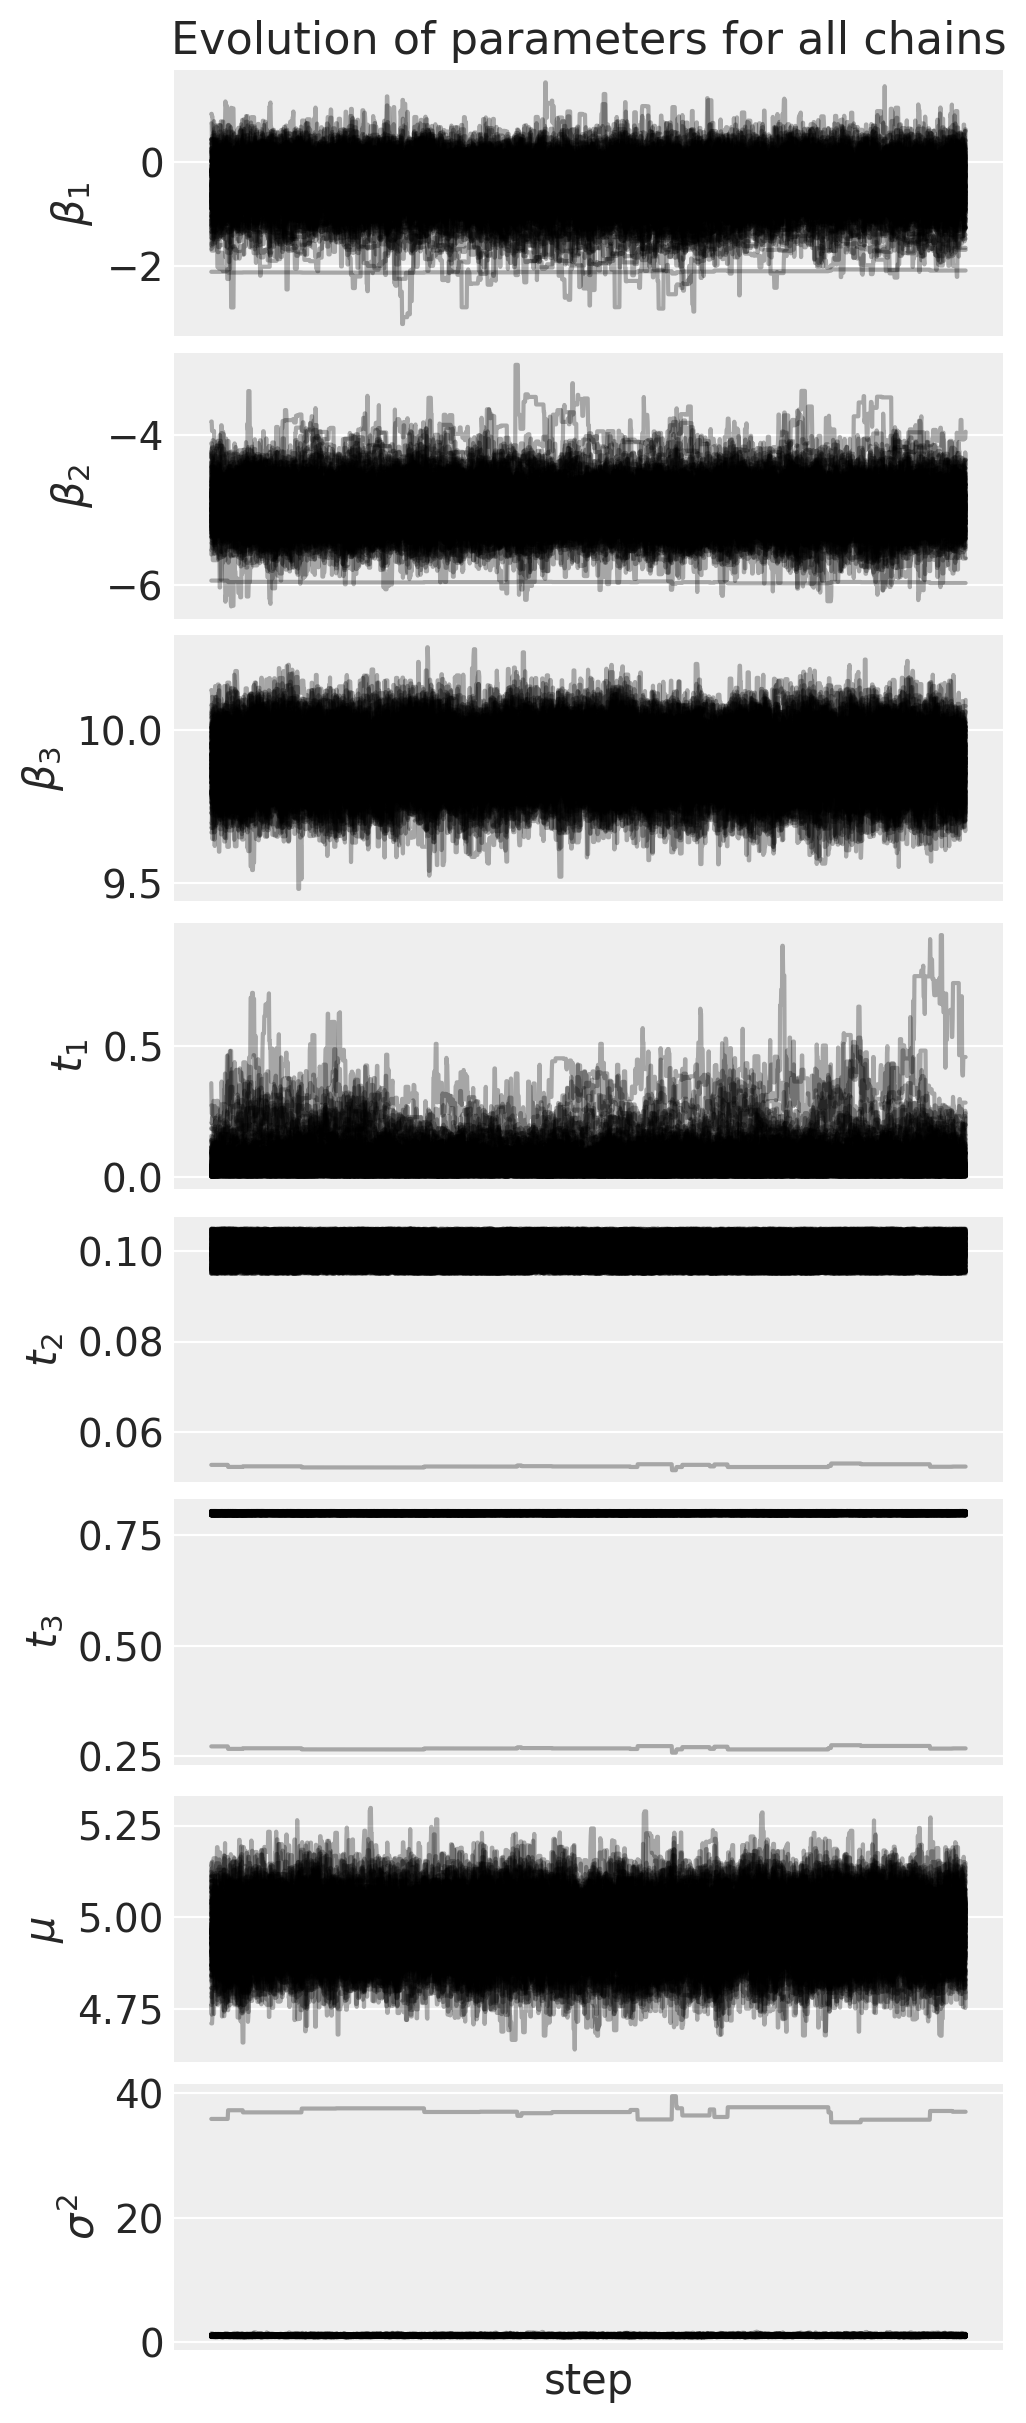

In [76]:
utils.plot_evolution(trace, labels)

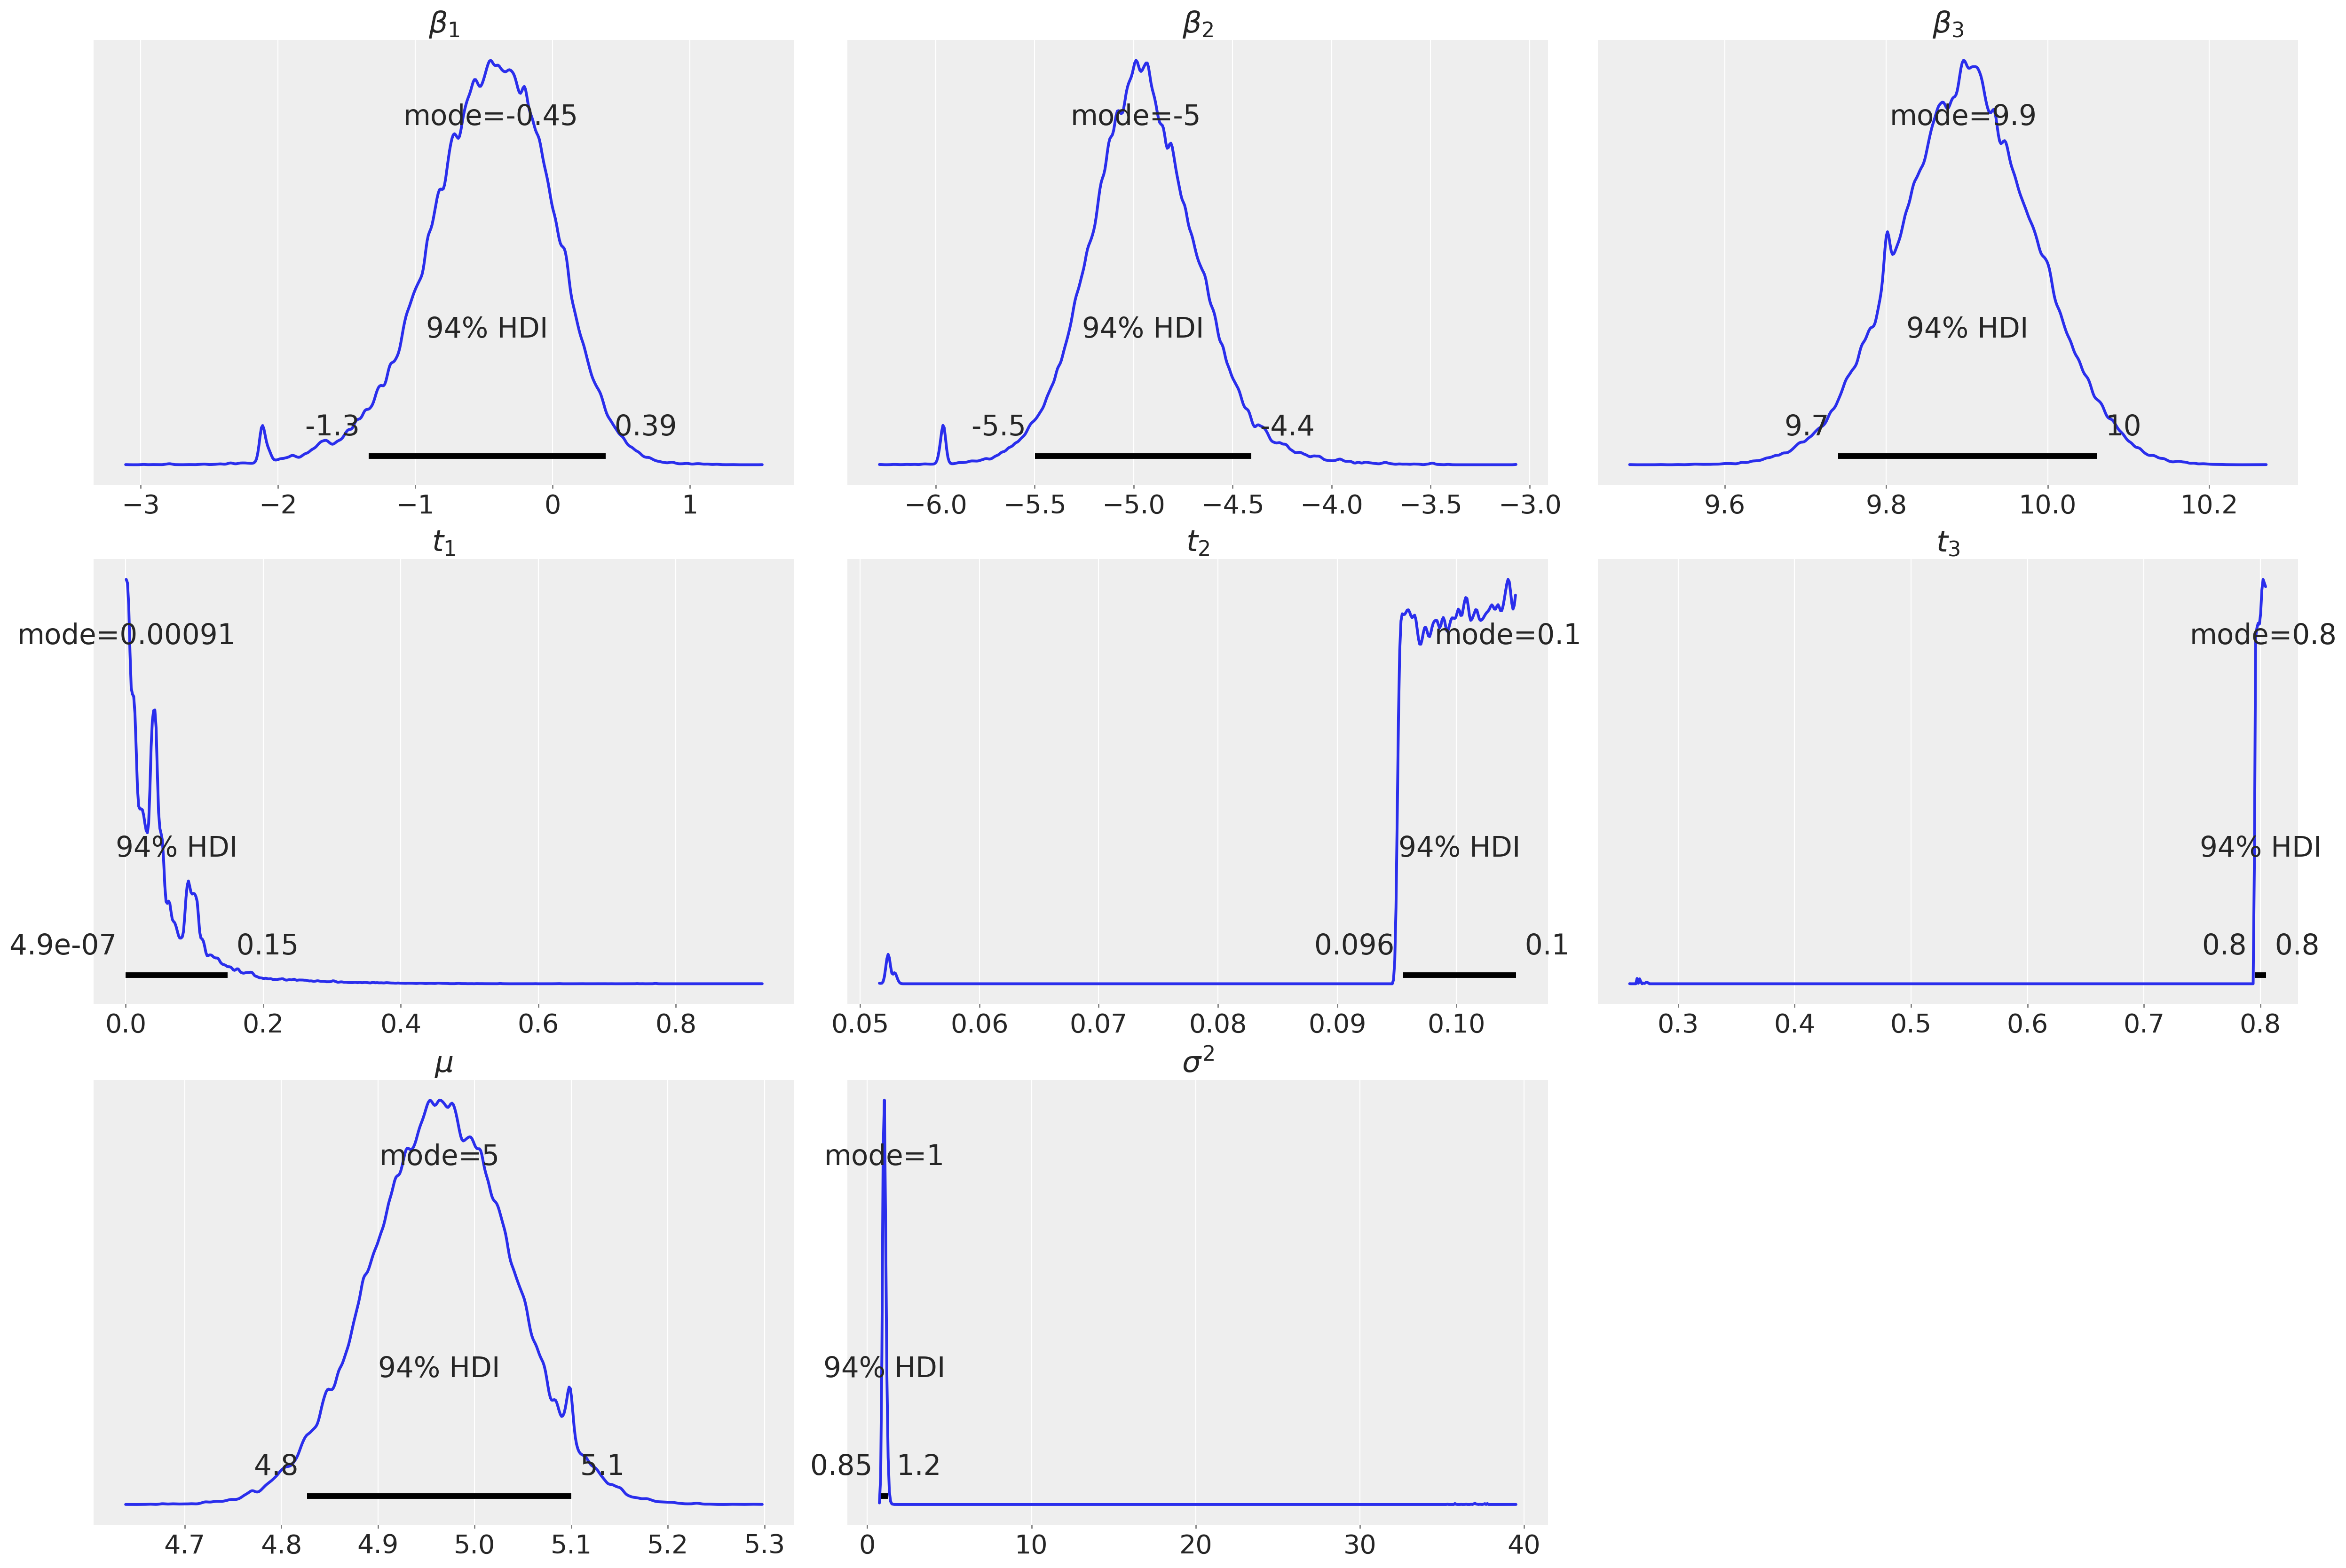

In [77]:
az.plot_posterior(idata_emcee, var_names=labels, point_estimate='mode',
                  grid=(NROWS(theta_ndim), NCOLS), textsize=20)

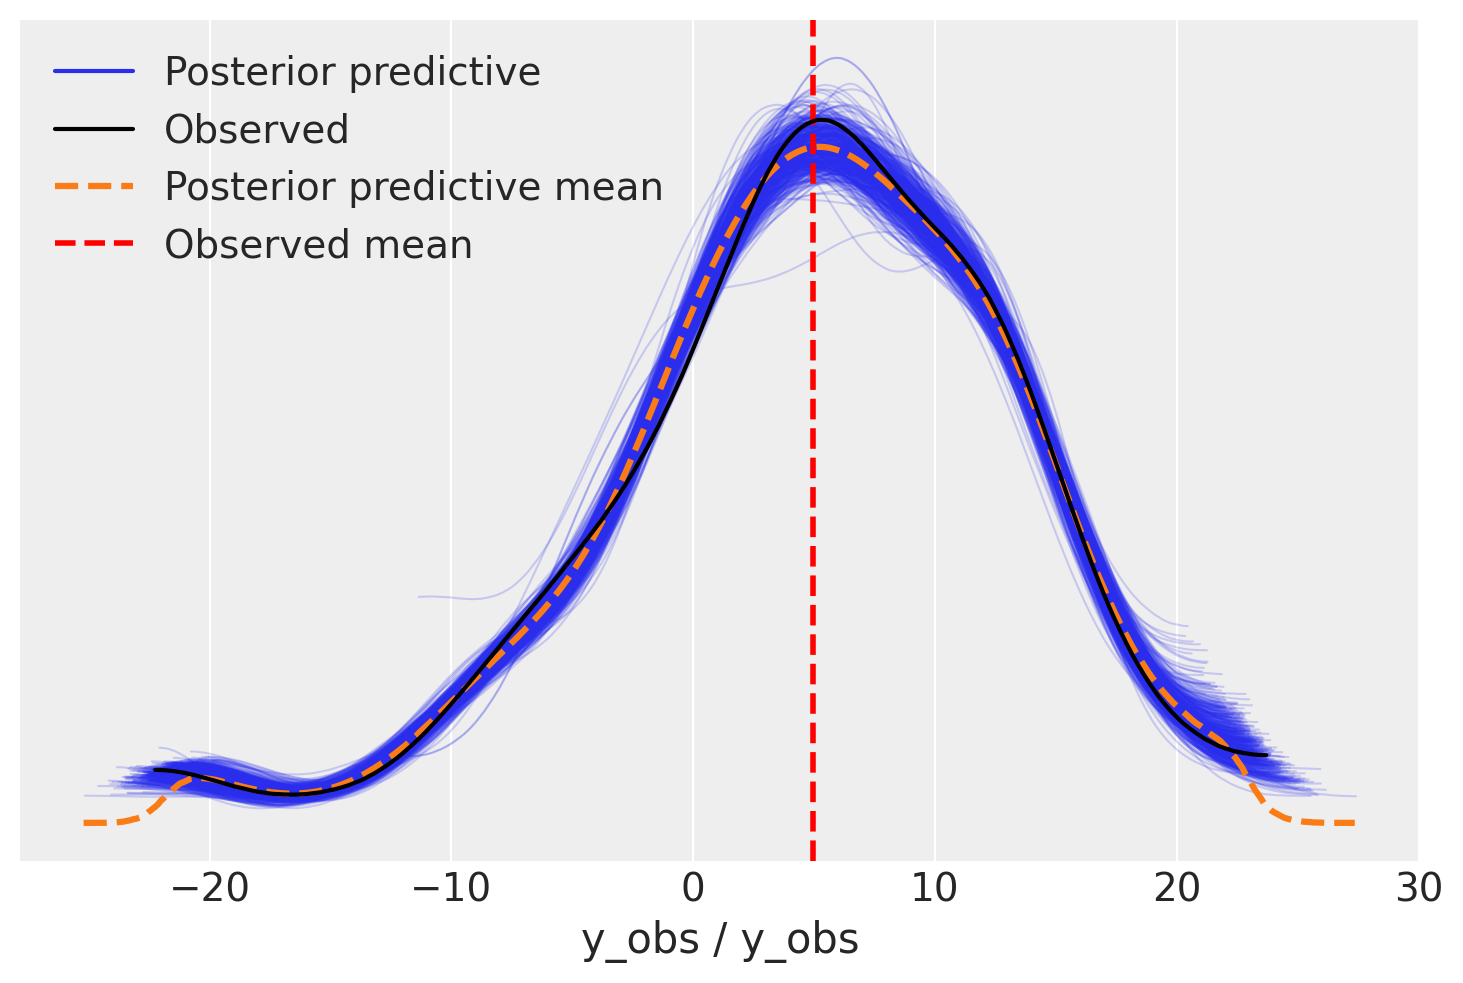

In [78]:
utils.plot_ppc(idata_emcee, y_obs=Y, n_samples=500, var_names=["y_obs"])

### Save & Load

In [79]:
with open("emcee-p-fixed.mcmc", 'wb') as file:
    pickle.dump(sampler, file)

In [ ]:
with open("emcee-p-fixed.mcmc", 'rb') as file:
    sampler = pickle.load(file)

## The PyMC library

In [11]:
import pymc3 as pm
import theano
import theano.tensor as tt

Some differences in the new release (see RELEASE-NOTES):

- Can pass distribution arguments (i.e RVs) to DensityDist. It has a new API.
- Model() accepts an `rng_seeder` argument to set the random seed.
- sample_posterior_predictive now returns an InferenceData object directly.
- shape vs ndim in Distributions?

### Model

In [92]:
def make_model(p, g, eta, X, Y, grid):
    b0 = g*rng.standard_normal(size=p)
    X_t = theano.shared(X)  # Transform X into Theano tensor

    with pm.Model() as model:
        mu_and_log_sigma = pm.DensityDist(
            'mu_and_log_sigma', lambda x: 0, shape=(2,))
        mu = pm.Deterministic('mu', mu_and_log_sigma[0])
        log_sigma = mu_and_log_sigma[1]
        mus = mu*np.ones_like(Y)
        sigma = pm.math.exp(log_sigma)
        sigma2 = pm.Deterministic(r"sigma2", sigma**2)

        tau = pm.Uniform('tau', 0.0, 1.0, shape=(p,))
        idx = np.abs(grid - tau[:, np.newaxis]).argmin(1)
        X_tau = X_t[:, idx]
        G_tau = pm.math.matrix_dot(X_tau.T, X_tau)
        G_tau = (G_tau + G_tau.T)/2.  # Enforce symmetry
        G_tau_reg = G_tau + eta * \
            tt.max(tt.nlinalg.eigh(G_tau)[0])*np.identity(p)

        def beta_lprior(x):
            b = x - b0

            return (0.5*pm.math.logdet(G_tau_reg)
                    - p*log_sigma
                    - pm.math.matrix_dot(b.T, G_tau_reg, b)/(2.*g*sigma2))

        beta = pm.DensityDist('beta', beta_lprior, shape=(p,))
        expected_obs = mus + pm.math.matrix_dot(X_tau, beta)

        y_obs = pm.Normal('y_obs', mu=expected_obs, sigma=sigma, observed=Y)

    return model

### Experiments

In [94]:
# NUTS with MLE as starting point
model_MLE = make_model(p_hat, g, eta, X, Y, grid)

with model_MLE:
    ttr = model_MLE.named_vars['tau'].transformation
    start = {"beta": mle_theta[:p_hat],
             "tau_interval__": ttr.forward(mle_theta[p_hat:2*p_hat]).eval(),
             "mu_and_log_sigma": mle_theta[-2:]}
    idata_mle = pm.sample(3000, cores=2, tune=2000, start=start,
                          target_accept=0.8, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau, mu_and_log_sigma]


Sampling 2 chains for 2_000 tune and 3_000 draw iterations (4_000 + 6_000 draws total) took 19 seconds.
There were 2255 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2209 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


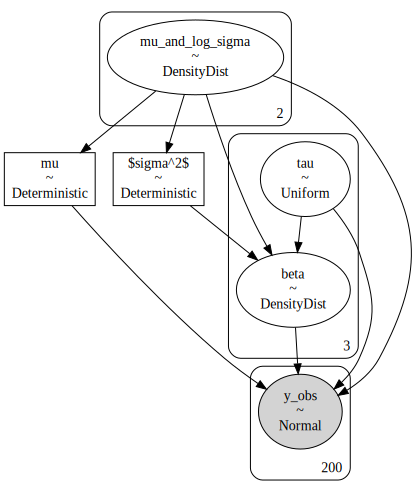

In [98]:
pm.model_graph.model_to_graphviz(model_MLE)

In [ ]:
utils.summary(idata_mle, theta_names)

In [ ]:
# NUTS with MAP as starting point
model_MAP = make_model(p_hat, g, eta, X, Y, grid)

with model_MAP:
    start = pm.find_MAP()
    idata_map = pm.sample(3000, cores=2, tune=2000, start=start,
                          target_accept=0.8, return_inferencedata=True)

In [ ]:
utils.summary(idata_map, theta_names)

In [ ]:
# NUTS with auto initialization
model_auto = make_model(p_hat, g, eta, X, Y, grid)

with model_auto:
    idata_auto = pm.sample(3000, cores=2, tune=2000, target_accept=0.8,
                           return_inferencedata=True)

In [ ]:
utils.summary(idata_auto, theta_names)

### Analysis

Since the tuning iterations already serve as burn-in, we keep the whole trace. In addition, we could consider thinning the samples.

In [ ]:
burn = 0
thin = 1

model = model_auto
idata_pymc = idata_auto
idata_pymc = idata_pymc.sel(draw=slice(burn, None, thin))

pm.model_graph.model_to_graphviz(model)

In [ ]:
az.plot_trace(idata_pymc, var_names=theta_names, labeller=labeller)
az.plot_posterior(idata_pymc,
                  point_estimate='mode',
                  var_names=theta_names,
                  labeller=labeller,
                  textsize=20,
                  grid=(NROWS(theta_ndim), NCOLS))

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(idata_pymc, var_names=["y_obs"])

In [ ]:
fig, ax = plt.subplots()
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc,
            model=model), ax=ax, num_pp_samples=500)
ax.axvline(Y.mean(), ls="--", color="r", lw=2, label="True mean")
ax.legend(loc="upper left")

### Save & Load

In [ ]:
with open("pymc-p-fixed.mcmc", 'wb') as file:
    pickle.dump(idata, file)

In [ ]:
with open("pymc-p-fixed.mcmc", 'rb') as file:
    idata = pickle.load(file)

## Notes

### Utility functions

- `az.plot_pairs`

### Alternative samplers

- `DeMetropolis(Z)`
- `Variational Inference in PyMC3`